## Cross-validation of sparse CCA

Predict expression of methylotrophy genes from methanotrophy genes.  Previously pooled on species.

First, run: ../notebooks/prepare_data/prepare_X_m_expression_Y_nmm_expression_Xval.ipynb

That fills /Users/janet/ML_meta-omics/data/cross_val_data

In [37]:
import sys
assert sys.version_info.major == 2, "python version is {}".format(sys.version_info.major)
print(sys.version)

2.7.12 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


In [38]:
import itertools
import matplotlib as mpl
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import subprocess
import sys

/Users/janet/miniconda3/envs/mlproj/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [39]:
print(sys.version)

2.7.12 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


In [40]:
sys.path.append('../../code/')

from CCA import CcaAnalysis, ExpressionCCA
from cross_validate import CrossValCCA

In [41]:
raw_data_path = '../../data/cross_val_data/'
os.listdir(raw_data_path)
xval_filenames = [f for f in os.listdir(raw_data_path) if '.tsv' in f]  # get rid of non-TSV files

In [42]:
def find_Xval_group(string):
    m = re.search('[_A-z]+fold([0-9]+)[._A-z]+', string)
    return int(m.group(1))

groups = list(set([find_Xval_group(f) for f in xval_filenames]))
groups

[1, 2, 3, 4]

In [43]:
def get_filename(strings_list, fold, train=True):
    raw_data_path = '../../data/cross_val_data/'
    xval_filenames = os.listdir(raw_data_path)
    
    potential_files = [f for f in xval_filenames
                       if "fold" + str(fold) in f]
    #print("There are {} potential files".format(len(potential_files)))
    
    for s in strings_list:
        potential_files = [f for f in potential_files if s in f]
        
    assert len(potential_files) == 1, "file name matches: {}".format(potential_files)
    
    #print("file names found: {}".format(potential_files))
    return potential_files[0]

In [44]:
get_filename(['methanotroph', 'train', 'filtered', 'ss'], fold=1, train=True)

'methanotroph_fold1_ss_filtered_train.tsv'

In [45]:
! ls ../../data/cross_val_data/methanotroph_fold1_ss_filtered_genes.tsv

../../data/cross_val_data/methanotroph_fold1_ss_filtered_genes.tsv


In [46]:
get_filename(['methanotroph', 'filtered', 'ss', 'genes'], fold=1, train=True)

'methanotroph_fold1_ss_filtered_genes.tsv'

In [47]:
summary = pd.DataFrame()

for fold in groups:
    file_specs = ['filtered', 'ss']
    #print('fold: {}'.format(fold))
    row = {}
    row['k'] = fold
    row['m filename, train'] = get_filename(['methanotroph', 'train'] + file_specs, fold)
    row['m filename, val'] = get_filename(['methanotroph', 'val'] + file_specs, fold)
    row['nmm filename, train'] = get_filename(['methylotroph', 'train'] + file_specs, fold)
    row['nmm filename, val'] = get_filename(['methylotroph', 'val'] + file_specs, fold)
    row['m gene names'] = get_filename(['methanotroph', 'genes'] + file_specs, fold)
    row['nmm gene names'] = get_filename(['methylotroph', 'genes'] + file_specs, fold)
    
    # make a dataframe row
    row = {k:[v] for k, v in row.items()}
    df = pd.DataFrame.from_dict(row)
    #print(df)
    summary = pd.concat([summary, df], axis=0)
summary

,k,"m filename, train","m filename, val",m gene names,"nmm filename, train","nmm filename, val",nmm gene names
0,1,methanotroph_fold1_ss_filtered_train.tsv,methanotroph_fold1_ss_filtered_val.tsv,methanotroph_fold1_ss_filtered_genes.tsv,methylotroph_fold1_ss_filtered_train.tsv,methylotroph_fold1_ss_filtered_val.tsv,methylotroph_fold1_ss_filtered_genes.tsv
0,2,methanotroph_fold2_ss_filtered_train.tsv,methanotroph_fold2_ss_filtered_val.tsv,methanotroph_fold2_ss_filtered_genes.tsv,methylotroph_fold2_ss_filtered_train.tsv,methylotroph_fold2_ss_filtered_val.tsv,methylotroph_fold2_ss_filtered_genes.tsv
0,3,methanotroph_fold3_ss_filtered_train.tsv,methanotroph_fold3_ss_filtered_val.tsv,methanotroph_fold3_ss_filtered_genes.tsv,methylotroph_fold3_ss_filtered_train.tsv,methylotroph_fold3_ss_filtered_val.tsv,methylotroph_fold3_ss_filtered_genes.tsv
0,4,methanotroph_fold4_ss_filtered_train.tsv,methanotroph_fold4_ss_filtered_val.tsv,methanotroph_fold4_ss_filtered_genes.tsv,methylotroph_fold4_ss_filtered_train.tsv,methylotroph_fold4_ss_filtered_val.tsv,methylotroph_fold4_ss_filtered_genes.tsv


### Run sparse CCA on each of these training sets

Start by demo of one set:

In [48]:
summary.head(1)

,k,"m filename, train","m filename, val",m gene names,"nmm filename, train","nmm filename, val",nmm gene names
0,1,methanotroph_fold1_ss_filtered_train.tsv,methanotroph_fold1_ss_filtered_val.tsv,methanotroph_fold1_ss_filtered_genes.tsv,methylotroph_fold1_ss_filtered_train.tsv,methylotroph_fold1_ss_filtered_val.tsv,methylotroph_fold1_ss_filtered_genes.tsv


In [49]:
uv_dir = './crossvalidation_u_and_v_vectors/'
if not os.path.exists(uv_dir):
    os.mkdir(uv_dir)

In [50]:
os.listdir(uv_dir)[0:4]

['fold1_ss_filtered_train_u_penX0.00909090909091_penZ0.00909090909091.tsv',
 'fold1_ss_filtered_train_u_penX0.0181818181818_penZ0.0181818181818.tsv',
 'fold1_ss_filtered_train_u_penX0.0272727272727_penZ0.0272727272727.tsv',
 'fold1_ss_filtered_train_u_penX0.0363636363636_penZ0.0363636363636.tsv']

In [51]:
def run_CCA(summary_df, cv, groups, pen_x, pen_z, verbose=False):
    
    for group in groups:
        fold_results = {}
        
        row = summary_df[summary_df['k'] == group]
        assert row.shape[0] == 1
        
        def prepare_filepath(set):
            filename = row[set][0]
            return os.path.join(raw_data_path, filename)
        
        x_filepath = prepare_filepath('m filename, train')
        print('x_filepath: {}'.format(x_filepath))
        z_filepath = prepare_filepath('nmm filename, train')
        print('z_filepath: {}'.format(z_filepath))
        x_val_filepath = prepare_filepath('m filename, val')
        print('x_val_filepath: {}'.format(x_val_filepath))
        z_val_filepath = prepare_filepath('nmm filename, val')
        print('z_val_filepath: {}'.format(z_val_filepath))
        x_gene_name_filepath = prepare_filepath('m gene names')
        print('x_gene_name_filepath: {}'.format(x_gene_name_filepath))
        z_gene_name_filepath = prepare_filepath('nmm gene names')
        print('z_gene_name_filepath: {}'.format(z_gene_name_filepath))
        
        cv.model(x_train_filepath=x_filepath,
                 z_train_filepath=z_filepath, 
                 pen_x = pen_x, 
                 pen_z = pen_z,
                 x_val_filepath = x_val_filepath, 
                 z_val_filepath = z_val_filepath, 
                 x_gene_filepath = x_gene_name_filepath,
                 z_gene_filepath = z_gene_name_filepath,
                 verbose=verbose)

## Hyperparameter tuning for 4-fold cross-val

In [52]:
cv = CrossValCCA(raw_data_path = '../../data/cross_val_data/', 
                 uv_dir = './crossvalidation_u_and_v_vectors',
                 input_filepath='../../data/cross_val_data/')

In [53]:
def run_CCA_specify_value_tupes(cross_val_obj, group_list, penx_penz_tuples, verbose=False):
     
    expected_models = len(penx_penz_tuples)
    print("analyze {} model(s) for crossvalidation sets {}".format(expected_models, groups))
    for t in penx_penz_tuples:
        penx, penz = t
        run_CCA(summary_df=summary, cv=cross_val_obj, groups=group_list, 
            pen_x=penx, pen_z=penz, verbose=verbose)

In [55]:
# demo
list(itertools.product([1, 2, 3], [4, 5, 6]))

[(1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6)]

In [58]:
# demo
np.arange(0, 0.5, 0.05)

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45])

In [59]:
for x in np.arange(0, 0.5, 0.05):
    run_CCA_specify_value_tupes(cross_val_obj=cv, 
                                group_list=[1, 2, 3, 4], 
                                penx_penz_tuples=[(x, x)], 
                                verbose=False)

analyze 1 model(s) for crossvalidation sets [1, 2, 3, 4]
x_filepath: ../../data/cross_val_data/methanotroph_fold1_ss_filtered_train.tsv
z_filepath: ../../data/cross_val_data/methylotroph_fold1_ss_filtered_train.tsv
x_val_filepath: ../../data/cross_val_data/methanotroph_fold1_ss_filtered_val.tsv
z_val_filepath: ../../data/cross_val_data/methylotroph_fold1_ss_filtered_val.tsv
x_gene_name_filepath: ../../data/cross_val_data/methanotroph_fold1_ss_filtered_genes.tsv
z_gene_name_filepath: ../../data/cross_val_data/methylotroph_fold1_ss_filtered_genes.tsv
read u in from ./crossvalidation_u_and_v_vectors/fold1_ss_filtered_train_u_penX0.0_penZ0.0.tsv
read v in from ./crossvalidation_u_and_v_vectors/fold1_ss_filtered_train_v_penX0.0_penZ0.0.tsv
x_filepath: ../../data/cross_val_data/methanotroph_fold2_ss_filtered_train.tsv
z_filepath: ../../data/cross_val_data/methylotroph_fold2_ss_filtered_train.tsv
x_val_filepath: ../../data/cross_val_data/methanotroph_fold2_ss_filtered_val.tsv
z_val_filepath: 

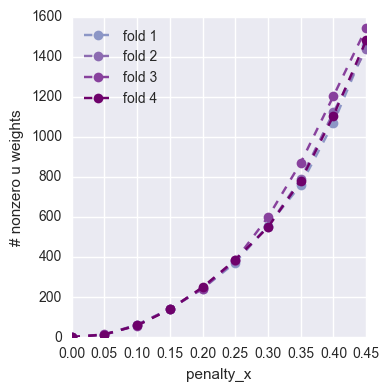

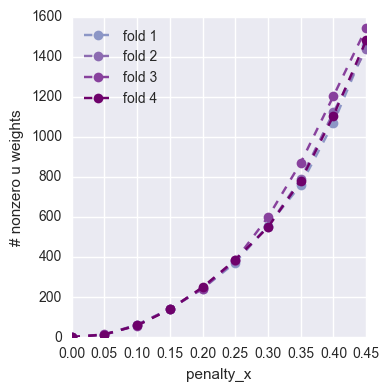

In [60]:
px = cv.plot_num_nonzero_coeffs_vs_penalty(set='x')
pz = cv.plot_num_nonzero_coeffs_vs_penalty(set='z')

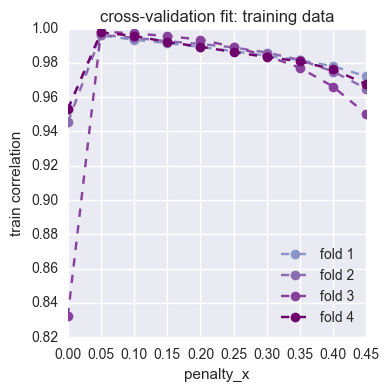

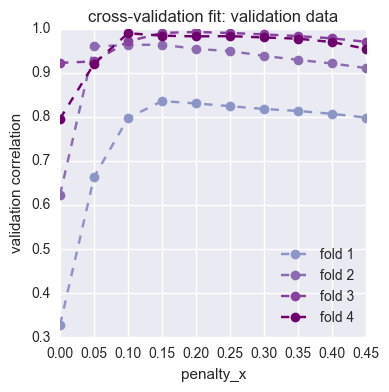

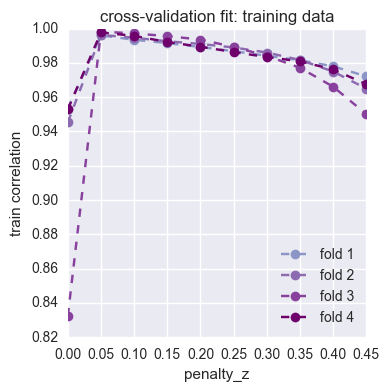

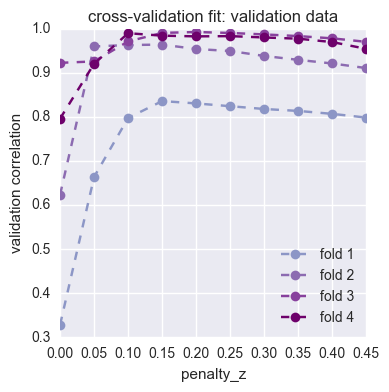

In [61]:
pxt = cv.plot_correlation_vs_penalty(set='train', penalty='x')
pxv = cv.plot_correlation_vs_penalty(set='val', penalty='x')

pzt = cv.plot_correlation_vs_penalty(set='train', penalty='z')
pzv = cv.plot_correlation_vs_penalty(set='val', penalty='z')

In [64]:
np.arange(0, 0.1, 0.02)

array([ 0.  ,  0.02,  0.04,  0.06,  0.08])

In [65]:
for x in [0.02,  0.04,  0.06]:
    run_CCA_specify_value_tupes(cross_val_obj=cv, 
                                group_list=[1, 2, 3, 4], 
                                penx_penz_tuples=[(x, x)], 
                                verbose=False)

analyze 1 model(s) for crossvalidation sets [1, 2, 3, 4]
x_filepath: ../../data/cross_val_data/methanotroph_fold1_ss_filtered_train.tsv
z_filepath: ../../data/cross_val_data/methylotroph_fold1_ss_filtered_train.tsv
x_val_filepath: ../../data/cross_val_data/methanotroph_fold1_ss_filtered_val.tsv
z_val_filepath: ../../data/cross_val_data/methylotroph_fold1_ss_filtered_val.tsv
x_gene_name_filepath: ../../data/cross_val_data/methanotroph_fold1_ss_filtered_genes.tsv
z_gene_name_filepath: ../../data/cross_val_data/methylotroph_fold1_ss_filtered_genes.tsv
read u in from ./crossvalidation_u_and_v_vectors/fold1_ss_filtered_train_u_penX0.02_penZ0.02.tsv
read v in from ./crossvalidation_u_and_v_vectors/fold1_ss_filtered_train_v_penX0.02_penZ0.02.tsv
x_filepath: ../../data/cross_val_data/methanotroph_fold2_ss_filtered_train.tsv
z_filepath: ../../data/cross_val_data/methylotroph_fold2_ss_filtered_train.tsv
x_val_filepath: ../../data/cross_val_data/methanotroph_fold2_ss_filtered_val.tsv
z_val_filepa

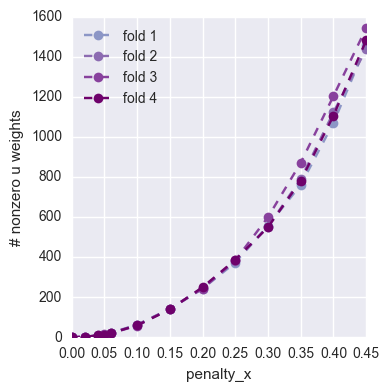

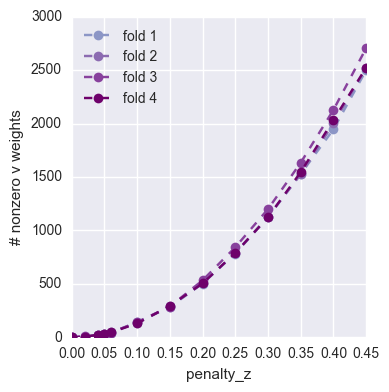

In [70]:
px2 = cv.plot_num_nonzero_coeffs_vs_penalty(set='x')
pz2 = cv.plot_num_nonzero_coeffs_vs_penalty(set='z')
px2.savefig('../../figures/161214_nonzeero_weights_x.pdf')
pz2.savefig('../../figures/161214_nonzeero_weights_z.pdf')

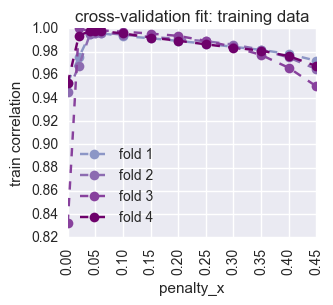

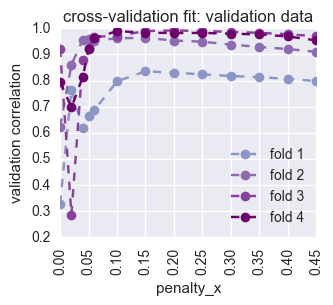

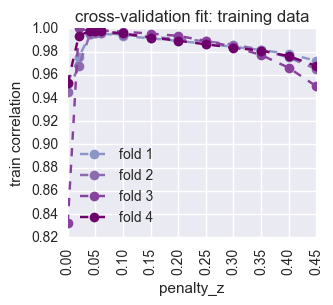

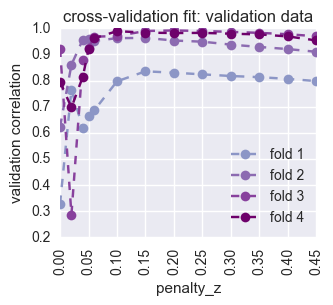

In [77]:
pxt2 = cv.plot_correlation_vs_penalty(set='train', penalty='x', figsize=(3.5, 3))
plt.xticks(rotation='vertical')
pxv2 = cv.plot_correlation_vs_penalty(set='val', penalty='x', figsize=(3.5, 3))
plt.xticks(rotation='vertical')
pzt2 = cv.plot_correlation_vs_penalty(set='train', penalty='z', figsize=(3.5, 3))
plt.xticks(rotation='vertical')
pzv2 = cv.plot_correlation_vs_penalty(set='val', penalty='z', figsize=(3.5, 3))
plt.xticks(rotation='vertical')

pxt2.savefig('../../figures/X_val_train_correlation--penalty_x.pdf')
pxv2.savefig('../../figures/X_val_validation_correlation--penalty_x.pdf')
pzt2.savefig('../../figures/X_val_train_correlation--penalty_z.pdf')
pzv2.savefig('../../figures/X_val_validation_correlation--penalty_z.pdf')

In [78]:
#import pickle
#with open('cross_validation_object.pkl', 'w') as f:
#   pickle.dump(cv,f)